# DS 3000 - Practicum 1 (Group 5)

#### Explain all steps to ensure that TAs can understand the output from your analysis. 
#### Note: the purpose of this practicum is to tell a story with the data. Ensure that your work is easy to understand.

## Question 1: Setting the Baseline - "Where Are We Now?" (15 points)

Create an executive dashboard (i.e. organized visualizations that are informative) showing the current state of aviation safety. Include:
* A line chart showing accidents vs. incidents for the most recent 20 years available in the dataset.
* A proportion chart comparing fatal vs. non-fatal events over time.
* A gauge or KPI card showing the current "safety score" (you define this metric). Ensure that you clearly define the metric and what factors are being considered in your calculation.
  
Insight Goal: Show how aviation safety have evolved. Has it progress or stagnated in any areas? Establish whether safety is improving and identify any concerning trends that need immediate attention. Explain your results.


In [19]:
# Data Prep for Q1
#   Year (from Event.Date)
#   InvestigationTypeNorm (normalized "Accident"/"Incident")
#   FatalEvent (binary flag)
#   WeightedInjury (for KPI)
#   df20 / idx20 / year_window (last 20 years subset)

# 1) Ensure Event.Date exists

# We rely on Event.Date for all time-based charts.
# If the column is missing, it's a hard-stop because the dashboard can't be built.
if "Event.Date" not in aviation_df.columns:
    raise KeyError(
        "Missing column 'Event.Date'. "
        "Your earlier prep should create/parse it. "
        "Without dates, we can't build 20-year trends."
    )


# 2) Guarantee Event.Date is truly datetime *right now*

# Why re-parse here?
#   • Jupyter notebooks are stateful—if you re-ran earlier cells in a different order,
#     Event.Date might have reverted to object/string/category.
#   • The .dt accessor ONLY works on datetime64 dtypes.
# errors='coerce' turns any unparsable strings into NaT (Not-a-Time) instead of crashing.
aviation_df["Event.Date"] = pd.to_datetime(
    aviation_df["Event.Date"],
    errors="coerce"          # invalid dates become NaT so we can safely drop them
)

# visibility to see if anything went wrong with parsing:
print("Event.Date dtype now:", aviation_df["Event.Date"].dtype)
print("Rows with unparseable Event.Date (NaT):", aviation_df["Event.Date"].isna().sum())

# 3) Derive Year from Event.Date (nullable Int64 for safety)

# Why Int64 (nullable) instead of int64?
#   • If a row had NaT for Event.Date, .dt.year returns NaN.
#   • Int64 pandas extension type can hold <NA> values; plain int64 cannot.
aviation_df["Year"] = aviation_df["Event.Date"].dt.year.astype("Int64")

# 4) Normalize Investigation.Type for clean grouping in the line chart

# This column distinguishes "Accident" vs "Incident".
# We title-case and trim to avoid issues like "accident", " ACCIDENT ", etc.
# If the column truly doesn't exist in your extract, we still create a placeholder
# so that code runs (you'll just get zeros for incidents).
if "Investigation.Type" in aviation_df.columns:
    aviation_df["InvestigationTypeNorm"] = (
        aviation_df["Investigation.Type"]
        # cast to string so .str methods are safe
        .astype(str)
        # remove leading/trailing whitespace
        .str.strip()     
        .str.title()  
    )
else:
    aviation_df["InvestigationTypeNorm"] = ""  # keeps downstream groupbys from breaking

# 5) Build FatalEvent flag from your numeric injury columns 

# Earlier prep already converted these to numeric Int64 with missing handled.
# Still check presence to fail fast if columns were renamed or dropped.
needed_injury_cols = ["Total.Fatal.Injuries", "Total.Serious.Injuries", "Total.Minor.Injuries"]
missing_cols = [c for c in needed_injury_cols if c not in aviation_df.columns]
if missing_cols:
    raise KeyError(
        f"Missing expected numeric injury columns: {missing_cols}. "
        "Check the earlier prep cell that casts injury columns."
    )

# Fill NA with 0 for safe arithmetic (Int64 can contain <NA>; math with <NA> propagates NA)
t_fatal   = aviation_df["Total.Fatal.Injuries"].fillna(0)
t_serious = aviation_df["Total.Serious.Injuries"].fillna(0)
t_minor   = aviation_df["Total.Minor.Injuries"].fillna(0)

# FatalEvent is a binary label used by the proportion chart.
# Any row with at least one fatal injury counts as a fatal event.
aviation_df["FatalEvent"] = (t_fatal > 0).astype(int)

# 6) WeightedInjury — single severity score for KPI metric

# We want a scalar that increases with outcome severity.
# Fatalities are far more consequential - weight = 3
# Serious injuries still significant - weight = 1
# Minor injuries less severe - weight = 0.5
# This is a tunable modeling choice that we document in our markdown.
aviation_df["WeightedInjury"] = 3.0 * t_fatal + 1.0 * t_serious + 0.5 * t_minor


# 7) Create a clean DataFrame with valid years only for time operations

# We drop rows where Year is <NA> (i.e., Event.Date could not be parsed).
df_years = aviation_df[aviation_df["Year"].notna()].copy()

# Convert Year from nullable Int64 to plain int for indexing/plotting convenience.
df_years["Year"] = df_years["Year"].astype(int)

# Safety check: if everything was NaT (no valid dates), we cannot proceed.
if df_years.empty:
    raise ValueError(
        "After parsing, there are no valid Event.Date values to compute Year. "
        "Check the input file or earlier parsing rules."
    )

# 8) Compute the 20-year analysis window used by ALL Q1 visuals

# max_year is the latest year present in the dataset (not necessarily the present calendar year).
# year_window is an inclusive list of the 20 most recent years: [max_year-19, ..., max_year].
max_year = int(df_years["Year"].max())
year_window = list(range(max_year - 19, max_year + 1))

# Filter to only those 20 years; this ensures every chart uses the same scope.
df20 = df_years[df_years["Year"].isin(year_window)].copy()

# Build a pandas Index of the years for easy reindexing in plots (fills missing years with 0).
idx20 = pd.Index(year_window, name="Year")


# 9) sanity prints
print(
    f"[Q1 PREP COMPLETE] Window: {year_window[0]}–{year_window[-1]} | "
    f"Rows kept: {len(df20)} | Latest year in data: {max_year}"
)
print("Columns now ready for Q1:", ["Year", "InvestigationTypeNorm", "FatalEvent", "WeightedInjury"])


Event.Date dtype now: datetime64[ns]
Rows with unparseable Event.Date (NaT): 0
[Q1 PREP COMPLETE] Window: 2003–2022 | Rows kept: 34911 | Latest year in data: 2022
Columns now ready for Q1: ['Year', 'InvestigationTypeNorm', 'FatalEvent', 'WeightedInjury']


### Line Chart: showing accidents vs. incidents for the most recent 20 years available in the dataset.

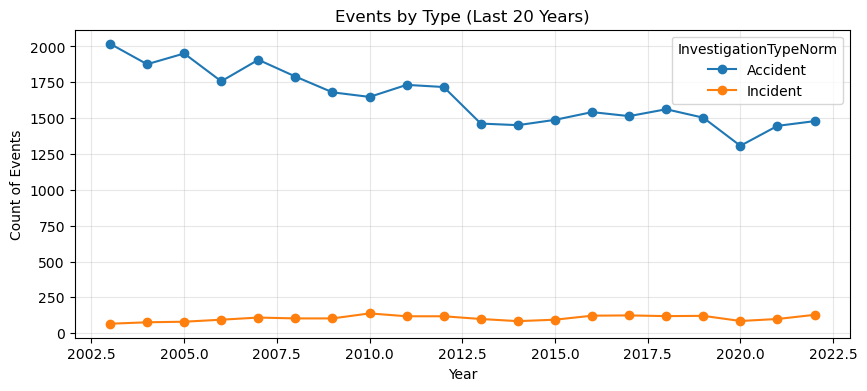

In [25]:
# Group the dataset by Year and InvestigationTypeNorm (Accident/Incident).
# .size() counts how many rows fall into each combination.
# .unstack() pivots the InvestigationTypeNorm values into columns for easier plotting.
# .reindex(idx20) ensures all years in the 20-year window appear, even if some have 0 counts.
counts_by_year_type = (
    df20.groupby(["Year","InvestigationTypeNorm"])
        .size()
        .unstack(fill_value=0)
        .reindex(idx20, fill_value=0)
)

# Plot the line chart.
# Each column (Accident/Incident) will become its own line.
ax = counts_by_year_type.plot(figsize=(10,4), marker="o")
# Chart title
ax.set_title("Events by Type (Last 20 Years)")
# X-axis label
ax.set_xlabel("Year")
# Y-axis label
ax.set_ylabel("Count of Events")
# Add light gridlines for readability
ax.grid(True, alpha=0.3)                        

### A proportion chart comparing fatal vs. non-fatal events over time.

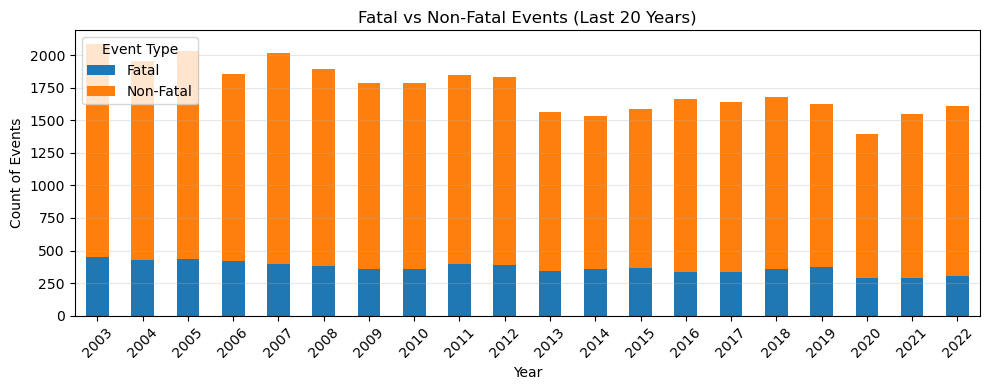

In [28]:
# fatal_by_year:
#   Counts how many fatal events occurred each year.
#   This was already calculated earlier.
#   Each row corresponds to a single year in the 20-year analysis window.
#   Values represent the total number of events in that year with ≥1 fatal injury.
fatal_by_year = (
    df20.groupby("Year")["FatalEvent"].sum()
        .reindex(idx20, fill_value=0)
)

# total_by_year:
# Group by year and count the number of events in each year.
total_by_year = df20.groupby("Year").size()

# Make sure all years in the 20-year window are present.
# If some years have no events, we'll manually fill those with 0.
for year in year_window:
    if year not in total_by_year.index:
        total_by_year.loc[year] = 0

# Sort by year so the plot comes out in chronological order.
total_by_year = total_by_year.sort_index()

# fatal_nonfatal DataFrame:
#   Construct a 2-column DataFrame where:
#   - "Fatal" holds the yearly counts of fatal events
#   - "Non-Fatal" is simply total events minus fatal events
#   .fillna(0) ensures there are no NaNs left after subtraction.
fatal_nonfatal = pd.DataFrame({
    "Fatal": fatal_by_year,
    "Non-Fatal": (total_by_year - fatal_by_year)
}).fillna(0)

# Plotting:
#   We use a stacked bar chart (kind="bar", stacked=True)
#   Each bar represents a single year.
#   The bar is split into two stacked segments:
#       • bottom = Fatal events
#       • top = Non-Fatal events
#   This makes it easy to compare both absolute and relative volumes year-to-year.
ax = fatal_nonfatal.plot(
    kind="bar",           # bar chart
    stacked=True,         # stack fatal + non-fatal on top of each other
    figsize=(10, 4)       # set figure size for readability
)

# Chart formatting:
ax.set_title("Fatal vs Non-Fatal Events (Last 20 Years)")
ax.set_xlabel("Year")                                     
ax.set_ylabel("Count of Events")                 

# Rotate x-axis tick labels for better readability if there are many years.
plt.xticks(rotation=45)

# Add a grid to make values easier to read visually.
ax.grid(axis="y", alpha=0.3)

# Add legend to distinguish Fatal vs Non-Fatal segments.
ax.legend(title="Event Type", loc="upper left")

plt.tight_layout()  # Adjust layout so labels/titles fit nicely
plt.show()

### A gauge or KPI card showing the current "safety score" (you define this metric). 
- Clearly define the metric and what factors are being considered in the calculation.

In [30]:
# Step 1: Define the baseline and current periods
# We'll compare the average severity from the first 3 years vs the last 3 years.
start3 = [year_window[0], year_window[0]+1, year_window[0]+2]
end3   = [year_window[-3], year_window[-2], year_window[-1]]

# Step 2: Helper function to compute severity rate
# Severity rate = total weighted injuries / total events in that period.
# WeightedInjury is a custom severity metric we defined earlier:
# 3×Fatal + 1×Serious + 0.5×Minor injuries.
def _severity_rate(years):
    sub = df20[df20["Year"].isin(years)]
    if len(sub) == 0:
        return np.nan   # handle edge case if no data in that range
    return sub["WeightedInjury"].sum() / len(sub)

# Compute severity rates for baseline (early period) and current (recent period).
baseline_rate = _severity_rate(start3)
current_rate  = _severity_rate(end3)

# Step 3: Calculate Safety Score
# Formula:
#   SafetyScore = 100 × ( 1 - min(1, current_rate / baseline_rate) )
#
# Interpretation:
#   - If current severity <= baseline → ratio ≤ 1 → Score between 0–100.
#   - If current severity >= baseline → ratio ≥ 1 → Score capped at 0.
if np.isnan(baseline_rate) or baseline_rate == 0:
    safety_score = np.nan  # can't compute if baseline invalid
else:
    ratio = (current_rate / baseline_rate)
    safety_score = 100 * (1 - min(1.0, max(0.0, ratio)))

# Print summary values for reporting.
print(f"Baseline (first 3 yrs) severity rate: {baseline_rate:.3f}")
print(f"Current  (last  3 yrs) severity rate: {current_rate:.3f}")
print(f"Safety Score (0–100): {safety_score:.1f}")


# Step 4: (Optional) Display KPI card as a small table
# Summarize key safety metrics in a neat table for executive dashboards.
kpi = pd.DataFrame({
    "Metric": ["Events (last 3y)", "Fatal share (last 3y, %)", "Severity rate (last 3y)", "Safety Score (0-100)"],
    "Value": [
        int(total_by_year.loc[end3].sum()),  # total events last 3 years
        float((fatal_by_year.loc[end3].sum() / total_by_year.loc[end3].sum())*100) if total_by_year.loc[end3].sum() else np.nan,
        round(current_rate, 3) if not np.isnan(current_rate) else np.nan,
        round(safety_score, 1) if not np.isnan(safety_score) else np.nan
    ]
})

# Display KPI table nicely in notebook
display(kpi)

Baseline (first 3 yrs) severity rate: 2.387
Current  (last  3 yrs) severity rate: 1.696
Safety Score (0–100): 28.9


,Metric,Value
0,Events (last 3y),4544.000000
1,"Fatal share (last 3y, %)",19.432218
2,Severity rate (last 3y),1.696000
3,Safety Score (0-100),28.900000


## Question 2: Risk Factors - "What are contributory factors?" (20 points)

Perform a multi-dimensional analysis using at least 4-5 visualizations that tell a compelling story about risk factors. Consider:
* Which combinations of factors create the highest risk (e.g. Weather conditions, type of aircraft, purpose of flight, etc.)?
* Are there "hidden" risk patterns that might not be obvious?
* Did any risk evolve over time for different categories?

Insight Goal: Identify the specific combinations of factors that reveal the highest risk, and whether new risk patterns are emerging.

### Weather condition vs. average security

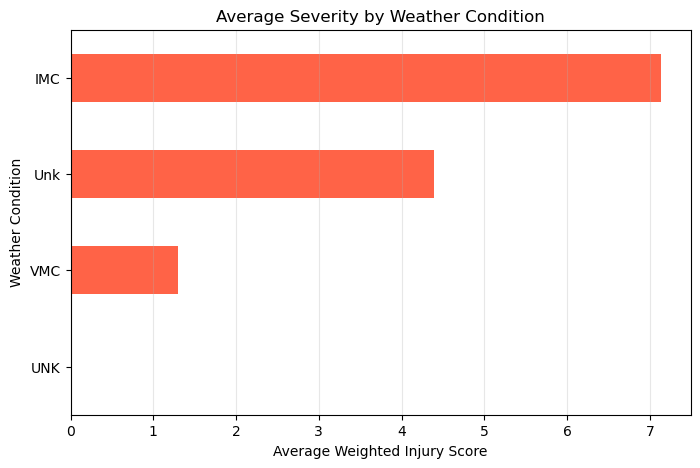

In [32]:
# Group the data by weather condition.
# Calculate the average WeightedInjury for each weather category.
# Sort the result from highest to lowest severity to highlight riskier conditions.
weather_risk = (
    df20.groupby("Weather.Condition")["WeightedInjury"]
    .mean()
    .sort_values(ascending=False)
)

# Create a horizontal bar chart for easier comparison.
plt.figure(figsize=(8,5))
weather_risk.plot(kind="barh", color="tomato")

# Add a descriptive title.
plt.title("Average Severity by Weather Condition")

# Label the x-axis to indicate the metric being shown.
plt.xlabel("Average Weighted Injury Score")

# Label the y-axis to indicate the categories.
plt.ylabel("Weather Condition")

# Reverse the order so that the highest severity is at the top of the chart.
plt.gca().invert_yaxis()

# Add a light grid along the x-axis to make the values easier to read.
plt.grid(axis="x", alpha=0.3)

# Show the plot.
plt.show()

#### Weather Conditions and Accident Severity

This chart compares the average severity of aviation accidents under different weather conditions. IMC (Instrument Meteorological Conditions), which typically involve poor visibility and more complex navigation, shows the highest average severity scores by a large margin. This indicates that accidents in IMC are much more likely to involve fatalities or serious injuries compared to those in VMC (Visual Meteorological Conditions). 

The “Unknown” category is also relatively high, which may reflect incomplete reporting or ambiguous weather situations. Overall, this highlights **adverse weather as a major risk factor** that significantly increases accident severity.


### Aircraft category vs. average severity

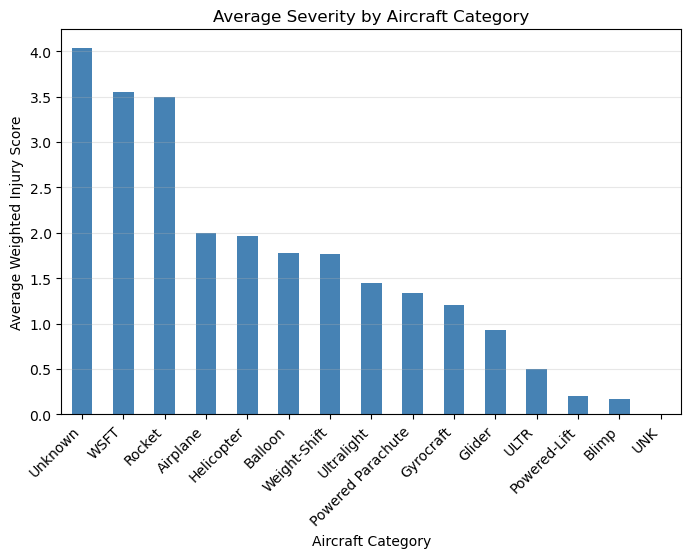

In [33]:
# Group the data by aircraft category.
# Calculate the average WeightedInjury score for each category.
# Sort from highest to lowest severity to identify riskier aircraft types.
aircraft_risk = (
    df20.groupby("Aircraft.Category")["WeightedInjury"]
    .mean()
    .sort_values(ascending=False)
)

# Create a vertical bar chart to compare severity across aircraft categories.
plt.figure(figsize=(8,5))
aircraft_risk.plot(kind="bar", color="steelblue")

# Add a descriptive title.
plt.title("Average Severity by Aircraft Category")

# Label the y-axis to indicate what is being measured.
plt.ylabel("Average Weighted Injury Score")

# Label the x-axis to indicate the categories.
plt.xlabel("Aircraft Category")

# Rotate the x-axis labels for readability if category names are long.
plt.xticks(rotation=45, ha="right")

# Add a light grid along the y-axis to make comparisons easier.
plt.grid(axis="y", alpha=0.3)

# Show the plot.
plt.show()

#### Aircraft Categories and Associated Risks

This chart shows the average severity of accidents across different aircraft categories. Some categories, such as WSFT (Weight-Shift), Rockets, and Airplanes, have relatively high severity scores, while others such as Gliders and Powered-Lift aircraft show lower severity levels. Helicopters also rank moderately high, reflecting their more complex flight dynamics and operational environments.

These differences suggest that **aircraft type plays a meaningful role in the severity of aviation accidents**, with certain categories being more prone to severe outcomes than others. This may relate to differences in speed, maneuverability, flight operations, or typical flight conditions for each category.


### Purpose of flight vs fatal event rate

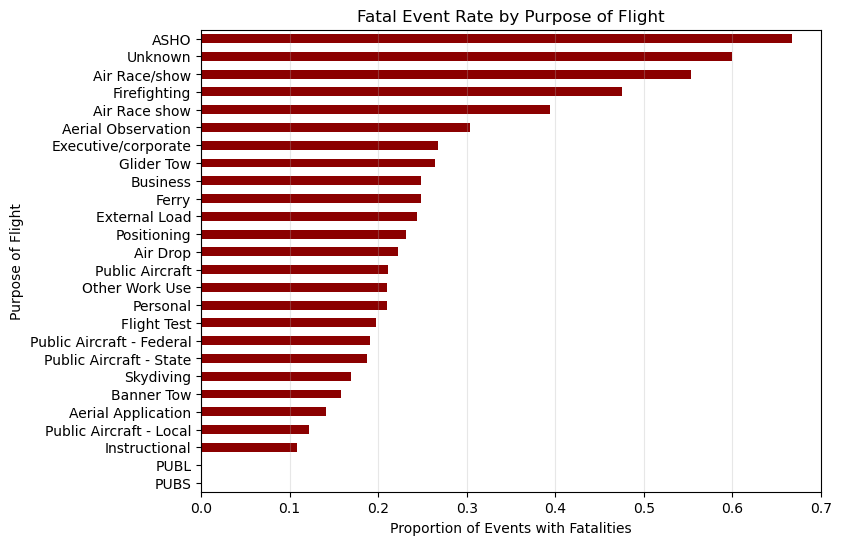

In [34]:

# Group the data by the purpose of flight.
# Calculate the average of the FatalEvent column, which gives the proportion of accidents that were fatal.
# Sort from highest to lowest fatal rate to see which flight purposes are riskier.
fatal_rate_by_purpose = (
    df20.groupby("Purpose.of.flight")["FatalEvent"]
    .mean()
    .sort_values(ascending=False)
)

# Create a horizontal bar chart for clearer comparison.
plt.figure(figsize=(8,6))
fatal_rate_by_purpose.plot(kind="barh", color="darkred")

# Add a descriptive title.
plt.title("Fatal Event Rate by Purpose of Flight")

# Label the x-axis to indicate that the values are proportions (0 to 1).
plt.xlabel("Proportion of Events with Fatalities")

# Label the y-axis to indicate the flight purpose categories.
plt.ylabel("Purpose of Flight")

# Reverse the order so the highest fatal rates appear at the top.
plt.gca().invert_yaxis()

# Add a light grid to the x-axis for readability.
plt.grid(axis="x", alpha=0.3)

# Show the plot.
plt.show()

#### Fatal Event Rates by Flight Purpose

This chart examines how the purpose of a flight relates to the likelihood of an accident being fatal. Activities such as air shows, firefighting, and aerial observation have some of the highest fatal event rates, exceeding 50% in some cases. These operations often occur in challenging conditions (e.g., low altitudes, risky maneuvers, or hazardous environments), which increases the probability of severe accidents.

In contrast, instructional flights and public aircraft operations show much lower fatal rates, likely due to more controlled environments and stricter safety protocols. This analysis reveals **operational purpose as a key risk factor**, with certain specialized or high-risk activities standing out.

### Risk over time by aircraft category

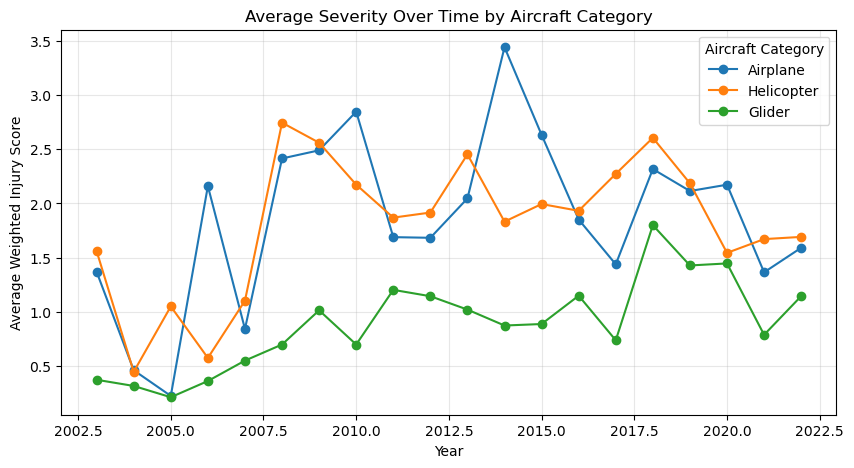

In [35]:
# Count the number of occurrences for each aircraft category.
# Select the top 3 categories with the most data to keep the plot simple and clear.
top_aircraft = df20["Aircraft.Category"].value_counts().head(3).index

# Filter the dataset to keep only those top 3 categories.
df_top = df20[df20["Aircraft.Category"].isin(top_aircraft)]

# Group the filtered data by Year and Aircraft Category.
# Calculate the average severity for each category in each year.
# Reset the index so Year and Aircraft.Category become normal columns for easy plotting.
risk_by_year = (
    df_top.groupby(["Year", "Aircraft.Category"])["WeightedInjury"]
    .mean()
    .reset_index()
)

# Create a line chart that shows each aircraft category's severity trend over time.
plt.figure(figsize=(10,5))

# Loop through each top aircraft category and plot its line separately.
for cat in top_aircraft:
    subset = risk_by_year[risk_by_year["Aircraft.Category"] == cat]
    plt.plot(subset["Year"], subset["WeightedInjury"], marker="o", label=cat)

# Add a descriptive title.
plt.title("Average Severity Over Time by Aircraft Category")

# Label the x-axis to show the timeline.
plt.xlabel("Year")

# Label the y-axis to show the average severity score.
plt.ylabel("Average Weighted Injury Score")

# Add a light grid to help compare trends.
plt.grid(True, alpha=0.3)

# Add a legend to identify each aircraft category line.
plt.legend(title="Aircraft Category")

# Show the plot.
plt.show()

#### Changes in Risk Over Time by Aircraft Category

This line chart tracks how the average severity of accidents has evolved over time for three major aircraft categories: airplanes, helicopters, and gliders. Airplanes and helicopters both show noticeable fluctuations, with several spikes indicating years of higher-severity accidents. Gliders consistently maintain a lower severity level, with relatively stable trends over the 20-year period.

While there is some year-to-year variability, the general patterns suggest that **risk levels have not uniformly improved across all categories**. Airplanes show some reduction in severity toward the later years, but helicopters remain relatively steady, indicating that different aircraft types may face distinct safety challenges over time.

### Weather x flight phase heatmap

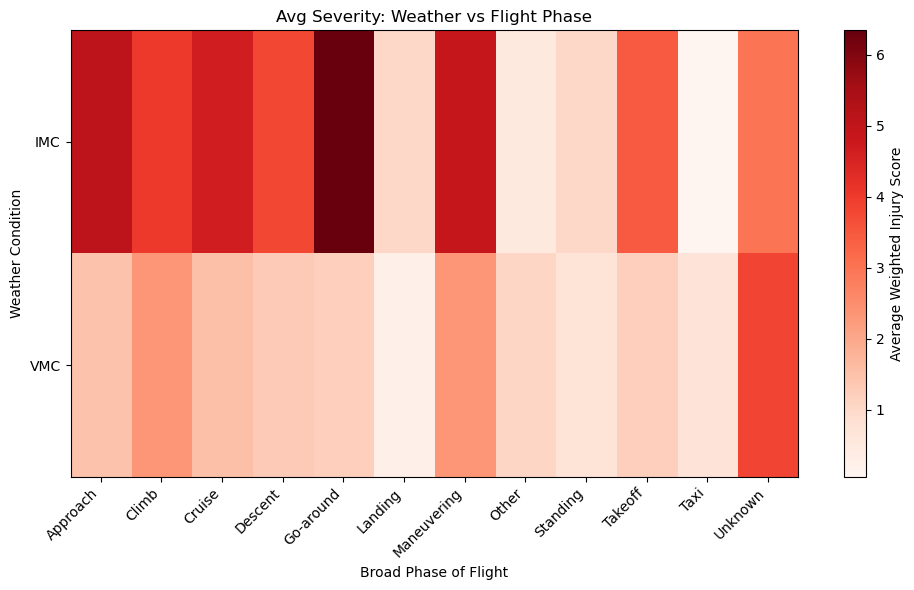

In [36]:
# Group the data by both Weather Condition and Broad Phase of Flight.
# Calculate the average WeightedInjury for each combination.
# Use unstack() to create a table where:
#    - Rows = Weather conditions
#    - Columns = Flight phases
combo_risk = df20.groupby(
    ["Weather.Condition", "Broad.phase.of.flight"]
)["WeightedInjury"].mean().unstack()

# Create a new figure for the heatmap.
plt.figure(figsize=(10,6))

# Use plt.imshow to create a simple heatmap of the combo_risk table.
# The "Reds" colormap uses light colors for low values and dark red for high severity.
plt.imshow(combo_risk, cmap="Reds", aspect="auto")

# Add a descriptive title to explain what this chart shows.
plt.title("Avg Severity: Weather vs Flight Phase")

# Label the x-axis for the flight phases.
plt.xlabel("Broad Phase of Flight")

# Label the y-axis for the weather conditions.
plt.ylabel("Weather Condition")

# Add x-axis tick labels for each flight phase.
plt.xticks(range(len(combo_risk.columns)), combo_risk.columns, rotation=45, ha="right")

# Add y-axis tick labels for each weather condition.
plt.yticks(range(len(combo_risk.index)), combo_risk.index)

# Add a colorbar to show the severity scale.
plt.colorbar(label="Average Weighted Injury Score")

# Adjust layout to make sure labels fit properly.
plt.tight_layout()

# Show the plot.
plt.show()

#### Interaction Between Weather and Flight Phase

This heatmap explores how accident severity varies depending on both the weather condition and the broad phase of flight. Darker shades indicate higher average severity. The combination of IMC weather and critical flight phases—such as landing, approach, and climb—stands out with the highest severity scores. These are typically the most demanding phases of flight, and adverse weather during these times can increase the likelihood of catastrophic outcomes.

In contrast, under VMC conditions, severity levels remain lower and more consistent across phases. This visualization highlights **the interaction between multiple risk factors**—specifically, how poor weather conditions combined with complex flight phases amplify accident severity.

### Summary of Findings for Question 2

Across all five analyses, several clear risk patterns emerge. First, **weather conditions** strongly influence accident severity, with IMC associated with far worse outcomes than VMC. **Aircraft category** is another key factor, as some types (e.g., WSFT, rockets, airplanes) experience more severe accidents than others. **Purpose of flight** also matters: specialized operations like air shows and firefighting show dramatically higher fatal rates compared to training or government flights.

Trends over time reveal that risk is not uniform across categories—while some improvements are visible for airplanes, helicopter accident severity remains more stable. Finally, **combinations of risk factors**, particularly bad weather during critical flight phases, lead to the most severe outcomes.

Together, these findings paint a multidimensional picture of aviation risk: it is shaped not by a single factor, but by the **interaction between weather, aircraft type, operational purpose, and flight phase**, with some risks evolving differently over time. These insights can guide targeted safety measures and policy interventions.